In [54]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import log_loss
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import GridSearchCV
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# %load ../src/weather_data_clean.py
import pandas as pd

def clean_weather_data(filename):
    """Take ASOS weather data file for Stampede pass and clean it ready for input to model.
    Input: txt file
    Output: pandas dataframe
    """
    data = pd.read_csv(filename)

    # Rename two of the columns
    data.rename(columns={'valid':'date', 'tmpf':'temp'}, inplace=True)

    # Remove the few rows that have a null value for temp
    data = data[~data.temp.eq('M')]

    # Remove spaces from column names
    data.rename(columns=lambda x: x.replace(' ', ''), inplace=True)

    # Only use the standard hourly weather reading at 56 mins past each hour
    mask = data['date'].apply(lambda x: x[-2:] == '56')
    data = data[mask]

    # Create a date series to be used in the clean dataframe
    date = pd.to_datetime(data['date'])

    # Create a temp series to be used in the clean dataframe
    temp = data['temp'].apply(float)

    # Cast the null value M to zero to enable create of the raw precipitation series cast to floats
    data.p01i[data.p01i == 'M'] = 0
    raw_precipitation = data['p01i'].apply(float)

    # Create a precipitation series to be used in the clean dataframe
    precipitation = raw_precipitation.apply(lambda x: True if (x > 0) else False)

    # Convert sky coverage data to clear or cloudy and create an overcast series to be used in the clean dataframe
    sky_elements = ['skyc1', 'skyc2', 'skyc3']
    data.skyc1 = data.skyc1.astype(str)
    data.skyc2 = data.skyc2.astype(str)
    data.skyc3 = data.skyc3.astype(str)
    sky_agg = data[sky_elements].values.tolist()
    sky_reduce = [['overcast' if (('BKN' in element) or ('OVC' in element) or ('VV' in element)) else 'clear'
                    for element in row] for row in sky_agg]
    overcast = pd.Series([True if 'overcast' in row else False for row in sky_reduce])
    overcast.index = date.index

    # Cast the null value 'M' to 10.00 to enable the creation of a poor visibility series
    data.vsby[data.vsby == 'M'] = 10.00
    raw_visibility = data['vsby'].apply(float)
    poor_visibility = pd.Series([True if value < 0.50 else False for value in raw_visibility])
    poor_visibility.index = date.index

    # Cast the null value 'M' to 0 to enable the creation of a windy series
    data.sknt[data.sknt == 'M'] = 0.00
    data.gust[data.gust == 'M'] = 0.00
    wind_speed = data['sknt'].apply(float)
    gust_speed = data['gust'].apply(float)
    wind_df = pd.concat([wind_speed, gust_speed], axis=1)
    # Finally apply the function f to enable the creation of the windy column
    windy = wind_df.apply(f, axis=1)

    """Create the cleaned dataframe by concatenating the date, temp, precipitation, overcast, poor_visibility
    and windy series"""
    df = pd.concat([date, temp, precipitation, overcast, poor_visibility, windy], axis=1)
    df.columns = ['date', 'temp', 'precipitation', 'overcast', 'poor_visibility', 'windy']
    cleaned_df = df[(df['date'] > '2006-12-31') & (df['date'] < '2018-04-03')]
    return cleaned_df

def f(row):
    """Function to be able to create the windy series with windy being true if wind speed is above 10 knots
    or gust speed is above 20 knots"""
    if row['sknt'] >= 10.00:
        val = True
    elif row['gust'] >= 20.00:
        val = True
    else:
        val = False
    return val




In [3]:
weather_df = clean_weather_data('ASOS_stampede_pass/SMP-2.txt')

/Users/leanne/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2802: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


In [4]:
# %load ../src/pass_data_clean.py
import pandas as pd

def clean_pass_data(filename):
    """Take Snoqualmie pass closure data file and clean it ready for input to model.
    Input: xlsx file
    Output: Pandas dataframe
    """
    data = pd.read_excel(filename, header=[1])

    #drop unnamed/unnecessary columns
    data.drop(data.columns[[11,12,13,14]], axis=1, inplace=True)

    #drop unnecessary secondary incident columns
    data.drop(data.columns[[1,8]], axis=1, inplace=True)

    #rename 'Incident...' columns to start_time and end_time 
    data.rename(columns={'INCIDENT START TIMES FOR EACH DIRECTION':'start_time'}, inplace=True)
    data.rename(columns={'INCIDENT END TIMES - DIRECTIONAL':'end_time'}, inplace=True)

    #use only dates from 2007-01-01 to match with available weather and traffic volume data
    df = data[(data['start_time'] > '2006-12-31')]

    #rename 'Delay Time Total' to delay
    df.rename(columns={'Delay Time Total':'delay'}, inplace=True)

    #drop row with nan value in delay
    df = df.dropna(subset=['delay'])

    #create a westbound pandas series with True if westbound and false if eastbound
    westbound = pd.Series([True if value == 'WB' else False for value in df.DIRECTION])

    #create a snow pandas series with True if weather description contains sn, false otherwise
    snow = df.WEATHER.str.contains('sn', case=False, na=False, regex=True)

    #create pandas series for start and end times
    start_time = pd.to_datetime(df['start_time'])
    end_time = pd.to_datetime(df['end_time'])

    #ensure that all the pandas series created have the same index
    westbound.index = start_time.index
    snow.index = start_time.index
    end_time.index = start_time.index

    #create cleaned df with the series created
    cleaned_df = pd.concat([start_time, end_time, westbound, snow], axis=1)

    #rename columns
    cleaned_df.rename(columns={0:'westbound', 'WEATHER':'snow'}, inplace=True)

    return cleaned_df



In [5]:
# %load ../src/combine_data.py

pass_closure_df = clean_pass_data('Cumulative_Snoqualmie_Pass_Delay_Closures_1992_2018.xlsx')

def get_pass_closure(date_time):
    """take a date_time and check if it is between the start and end times of a closure event
    input: datetime
    output: boolean
    """
    start_end_times = list(zip(pass_closure_df.start_time, pass_closure_df.end_time))
    for row in start_end_times:
        if row[0] <= date_time <= row[1]:
            return True
    return False

def add_pass_closed(df):
    """take the weather df and add a new column for whether or not the pass is closed at each date_time
    input: pandas dataframe
    output:pandas dataframe
    """
    df['pass_closed'] = df['date'].map(get_pass_closure)
    return df

/Users/leanne/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


In [6]:
combined_df = add_pass_closed(weather_df)

In [7]:
combined_df[['precipitation', 'overcast', 'poor_visibility', 'windy', 'pass_closed']] = (combined_df[['precipitation', 'overcast', 'poor_visibility', 'windy', 'pass_closed']] == True).astype(int)

In [68]:
combined_df

,date,temp,precipitation,overcast,poor_visibility,windy,pass_closed
date,,,,,,,
2006-12-31 23:56:00,2006-12-31 23:56:00,23.00,0,1,0,0,0
2007-01-01 00:56:00,2007-01-01 00:56:00,26.06,0,0,0,0,0
2007-01-01 01:56:00,2007-01-01 01:56:00,24.98,0,0,0,0,0
2007-01-01 02:56:00,2007-01-01 02:56:00,24.08,0,0,0,0,0
2007-01-01 03:56:00,2007-01-01 03:56:00,24.08,0,0,0,0,0
2007-01-01 05:56:00,2007-01-01 05:56:00,19.94,0,1,1,0,0
2007-01-01 10:56:00,2007-01-01 10:56:00,19.94,1,1,0,0,0
2007-01-01 11:56:00,2007-01-01 11:56:00,19.04,1,1,0,0,0
2007-01-01 12:56:00,2007-01-01 12:56:00,19.94,1,1,0,0,0


In [8]:
date_column = combined_df.date

In [9]:
month_day_of_week = pd.DataFrame({"year": date_column.dt.year,
                                  "month": date_column.dt.month, 
                                  "day": date_column.dt.day,
                                  "dayofweek": date_column.dt.dayofweek})

In [10]:
month_day_of_week.dayofweek[month_day_of_week.dayofweek == 0] = 'Monday'
month_day_of_week.dayofweek[month_day_of_week.dayofweek == 1] = 'Tuesday'
month_day_of_week.dayofweek[month_day_of_week.dayofweek == 2] = 'Wednesday'
month_day_of_week.dayofweek[month_day_of_week.dayofweek == 3] = 'Thursday'
month_day_of_week.dayofweek[month_day_of_week.dayofweek == 4] = 'Friday'
month_day_of_week.dayofweek[month_day_of_week.dayofweek == 5] = 'Saturday'
month_day_of_week.dayofweek[month_day_of_week.dayofweek == 6] = 'Sunday'

In [11]:
month_day_of_week = pd.get_dummies(month_day_of_week)

In [12]:
features = pd.concat([combined_df, month_day_of_week], axis=1)

In [13]:
features

,date,temp,precipitation,overcast,poor_visibility,windy,pass_closed,year,month,day,dayofweek_Friday,dayofweek_Monday,dayofweek_Saturday,dayofweek_Sunday,dayofweek_Thursday,dayofweek_Tuesday,dayofweek_Wednesday
0,2006-12-31 23:56:00,23.00,0,1,0,0,0,2006,12,31,0,0,0,1,0,0,0
1,2007-01-01 00:56:00,26.06,0,0,0,0,0,2007,1,1,0,1,0,0,0,0,0
2,2007-01-01 01:56:00,24.98,0,0,0,0,0,2007,1,1,0,1,0,0,0,0,0
3,2007-01-01 02:56:00,24.08,0,0,0,0,0,2007,1,1,0,1,0,0,0,0,0
4,2007-01-01 03:56:00,24.08,0,0,0,0,0,2007,1,1,0,1,0,0,0,0,0
5,2007-01-01 05:56:00,19.94,0,1,1,0,0,2007,1,1,0,1,0,0,0,0,0
6,2007-01-01 10:56:00,19.94,1,1,0,0,0,2007,1,1,0,1,0,0,0,0,0
7,2007-01-01 11:56:00,19.04,1,1,0,0,0,2007,1,1,0,1,0,0,0,0,0
8,2007-01-01 12:56:00,19.94,1,1,0,0,0,2007,1,1,0,1,0,0,0,0,0
9,2007-01-01 13:56:00,21.02,1,1,0,0,0,2007,1,1,0,1,0,0,0,0,0


In [14]:
features = features.drop(['date'], axis=1)

In [15]:
X_train, X_test, y_train, y_test = train_test_split(features.drop('pass_closed',axis=1), 
                                                    features['pass_closed'], test_size=0.20)

In [16]:
baseline = GradientBoostingClassifier(learning_rate=0.1, n_estimators=100,max_depth=3, min_samples_split=2, min_samples_leaf=1, subsample=1,max_features='sqrt', random_state=10)

In [17]:
baseline.fit(X_train,y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features='sqrt', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=10, subsample=1, verbose=0,
              warm_start=False)

In [18]:
probs = baseline.predict_proba(X_test)

In [19]:
probs[:,1].max()

0.927289557674724

In [20]:
probs[:,1].min()

0.001769163051868739

In [21]:
probs[:,1].mean()

0.023528206656664725

In [22]:
score = log_loss(y_test, probs)

In [23]:
score

0.04510538927006385

In [24]:
fpr, tpr, thresholds = roc_curve(y_test, probs[:,1])

In [25]:
roc_auc = auc(fpr, tpr)

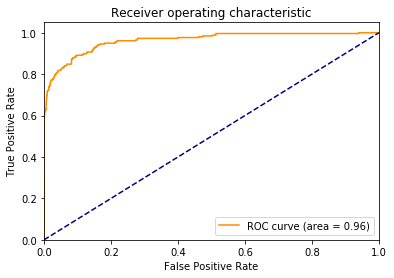

In [26]:
plt.figure()
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [27]:
probs

array([[0.99360917, 0.00639083],
       [0.99014097, 0.00985903],
       [0.99717022, 0.00282978],
       ...,
       [0.99267142, 0.00732858],
       [0.99562863, 0.00437137],
       [0.99256091, 0.00743909]])

In [28]:
combined_df.index = combined_df.date

In [29]:
daily_df = combined_df.resample("D").agg({'temp':'mean','precipitation':'max', 'overcast':'max', 'poor_visibility':'max', 'windy':'max', 'pass_closed':'max'})

In [30]:
daily_df.dropna(inplace=True)

In [31]:
date_column = pd.Series(daily_df.index)

In [32]:
month_day_of_week = pd.DataFrame({"year": date_column.dt.year,
                                  "month": date_column.dt.month, 
                                  "day": date_column.dt.day,
                                  "dayofweek": date_column.dt.dayofweek})

In [33]:
month_day_of_week.dayofweek[month_day_of_week.dayofweek == 0] = 'Monday'
month_day_of_week.dayofweek[month_day_of_week.dayofweek == 1] = 'Tuesday'
month_day_of_week.dayofweek[month_day_of_week.dayofweek == 2] = 'Wednesday'
month_day_of_week.dayofweek[month_day_of_week.dayofweek == 3] = 'Thursday'
month_day_of_week.dayofweek[month_day_of_week.dayofweek == 4] = 'Friday'
month_day_of_week.dayofweek[month_day_of_week.dayofweek == 5] = 'Saturday'
month_day_of_week.dayofweek[month_day_of_week.dayofweek == 6] = 'Sunday'

In [34]:
month_day_of_week = pd.get_dummies(month_day_of_week)

In [35]:
daily_df.reset_index()

,date,temp,precipitation,overcast,poor_visibility,windy,pass_closed
0,2006-12-31,23.000000,0.0,1.0,0.0,0.0,0.0
1,2007-01-01,28.253750,1.0,1.0,1.0,1.0,0.0
2,2007-01-02,41.735000,1.0,1.0,1.0,1.0,1.0
3,2007-01-03,32.993913,1.0,1.0,1.0,1.0,0.0
4,2007-01-04,26.682500,1.0,1.0,1.0,1.0,0.0
5,2007-01-05,32.030000,1.0,1.0,1.0,1.0,0.0
6,2007-01-06,28.385000,1.0,1.0,0.0,1.0,1.0
7,2007-01-07,34.310000,1.0,1.0,1.0,1.0,1.0
8,2007-01-08,32.922500,1.0,1.0,1.0,1.0,0.0
9,2007-01-09,35.971250,1.0,1.0,1.0,1.0,0.0


In [36]:
month_day_of_week.index = daily_df.index

In [37]:
features2 = pd.concat([daily_df, month_day_of_week], axis=1)

In [38]:
features2

,temp,precipitation,overcast,poor_visibility,windy,pass_closed,year,month,day,dayofweek_Friday,dayofweek_Monday,dayofweek_Saturday,dayofweek_Sunday,dayofweek_Thursday,dayofweek_Tuesday,dayofweek_Wednesday
date,,,,,,,,,,,,,,,,
2006-12-31,23.000000,0.0,1.0,0.0,0.0,0.0,2006,12,31,0,0,0,1,0,0,0
2007-01-01,28.253750,1.0,1.0,1.0,1.0,0.0,2007,1,1,0,1,0,0,0,0,0
2007-01-02,41.735000,1.0,1.0,1.0,1.0,1.0,2007,1,2,0,0,0,0,0,1,0
2007-01-03,32.993913,1.0,1.0,1.0,1.0,0.0,2007,1,3,0,0,0,0,0,0,1
2007-01-04,26.682500,1.0,1.0,1.0,1.0,0.0,2007,1,4,0,0,0,0,1,0,0
2007-01-05,32.030000,1.0,1.0,1.0,1.0,0.0,2007,1,5,1,0,0,0,0,0,0
2007-01-06,28.385000,1.0,1.0,0.0,1.0,1.0,2007,1,6,0,0,1,0,0,0,0
2007-01-07,34.310000,1.0,1.0,1.0,1.0,1.0,2007,1,7,0,0,0,1,0,0,0
2007-01-08,32.922500,1.0,1.0,1.0,1.0,0.0,2007,1,8,0,1,0,0,0,0,0


In [39]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(features2.drop('pass_closed',axis=1), 
                                                    features2['pass_closed'], test_size=0.20)

In [40]:
baseline2 = GradientBoostingClassifier(learning_rate=0.1, n_estimators=100,max_depth=3, min_samples_split=2, min_samples_leaf=1, subsample=1,max_features='sqrt', random_state=10)

In [41]:
baseline2.fit(X_train2,y_train2)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features='sqrt', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=10, subsample=1, verbose=0,
              warm_start=False)

In [42]:
probs2 = baseline2.predict_proba(X_test2)

In [43]:
probs2[:,1].max()

0.848126421661261

In [44]:
probs2[:,1].min()

0.00879111813483922

In [45]:
probs2[:,1].mean()

0.10091646618449747

In [46]:
score = log_loss(y_test2, probs2)

In [47]:
score

0.14457292721136006

In [48]:
fpr2, tpr2, thresholds2 = roc_curve(y_test2, probs2[:,1])

In [49]:
roc_auc = auc(fpr2, tpr2)

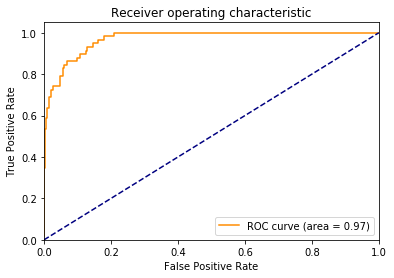

In [50]:
plt.figure()
plt.plot(fpr2, tpr2, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [51]:
probs2

array([[0.90863698, 0.09136302],
       [0.97037338, 0.02962662],
       [0.94398801, 0.05601199],
       ...,
       [0.90952415, 0.09047585],
       [0.91812112, 0.08187888],
       [0.98718024, 0.01281976]])

In [55]:
p_test3 = {'learning_rate':[0.15,0.1,0.05,0.01,0.005,0.001], 'n_estimators':[100,250,500,750,1000,1250,1500,1750]}

tuning = GridSearchCV(estimator =GradientBoostingClassifier(max_depth=4, min_samples_split=2, min_samples_leaf=1, subsample=1,max_features='sqrt', random_state=10), 
            param_grid = p_test3, scoring='accuracy',n_jobs=4,iid=False, cv=5)
tuning.fit(X_train2,y_train2)
tuning.grid_scores_, tuning.best_params_, tuning.best_score_

/Users/leanne/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:747: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.94033, std: 0.00667, params: {'learning_rate': 0.15, 'n_estimators': 100},
  mean: 0.93598, std: 0.00908, params: {'learning_rate': 0.15, 'n_estimators': 250},
  mean: 0.93511, std: 0.00967, params: {'learning_rate': 0.15, 'n_estimators': 500},
  mean: 0.93380, std: 0.00831, params: {'learning_rate': 0.15, 'n_estimators': 750},
  mean: 0.93467, std: 0.00900, params: {'learning_rate': 0.15, 'n_estimators': 1000},
  mean: 0.93467, std: 0.00900, params: {'learning_rate': 0.15, 'n_estimators': 1250},
  mean: 0.93467, std: 0.00900, params: {'learning_rate': 0.15, 'n_estimators': 1500},
  mean: 0.93467, std: 0.00900, params: {'learning_rate': 0.15, 'n_estimators': 1750},
  mean: 0.94120, std: 0.00567, params: {'learning_rate': 0.1, 'n_estimators': 100},
  mean: 0.93685, std: 0.00673, params: {'learning_rate': 0.1, 'n_estimators': 250},
  mean: 0.93728, std: 0.00679, params: {'learning_rate': 0.1, 'n_estimators': 500},
  mean: 0.93685, std: 0.00801, params: {'learning_rate': 0.1, 'n

In [56]:
p_test2 = {'max_depth':[2,3,4,5,6,7] }
tuning = GridSearchCV(estimator =GradientBoostingClassifier(learning_rate=0.01,n_estimators=1250, min_samples_split=2, min_samples_leaf=1, subsample=1,max_features='sqrt', random_state=10), 
            param_grid = p_test2, scoring='accuracy',n_jobs=4,iid=False, cv=5)
tuning.fit(X_train2,y_train2)
tuning.grid_scores_, tuning.best_params_, tuning.best_score_

/Users/leanne/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:747: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.94077, std: 0.00987, params: {'max_depth': 2},
  mean: 0.94164, std: 0.00864, params: {'max_depth': 3},
  mean: 0.94338, std: 0.00716, params: {'max_depth': 4},
  mean: 0.94251, std: 0.00908, params: {'max_depth': 5},
  mean: 0.94208, std: 0.01044, params: {'max_depth': 6},
  mean: 0.94207, std: 0.00866, params: {'max_depth': 7}],
 {'max_depth': 4},
 0.9433797480344795)

In [57]:
model1 = GradientBoostingClassifier(learning_rate=0.01, n_estimators=1250,max_depth=4, min_samples_split=2, min_samples_leaf=1, subsample=1,max_features='sqrt', random_state=10)

In [58]:
model1.fit(X_train2,y_train2)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.01, loss='deviance', max_depth=4,
              max_features='sqrt', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=1250,
              presort='auto', random_state=10, subsample=1, verbose=0,
              warm_start=False)

In [59]:
model1_probs = baseline2.predict_proba(X_test2)

In [60]:
model1_probs[:,1].max()

0.848126421661261

In [61]:
model1_probs[:,1].min()

0.00879111813483922

In [62]:
model1_probs[:,1].mean()

0.10091646618449747

In [63]:
score = log_loss(y_test2, model1_probs)

In [64]:
score

0.14457292721136006

In [65]:
fpr2, tpr2, thresholds2 = roc_curve(y_test2, model1_probs[:,1])

In [66]:
roc_auc = auc(fpr2, tpr2)

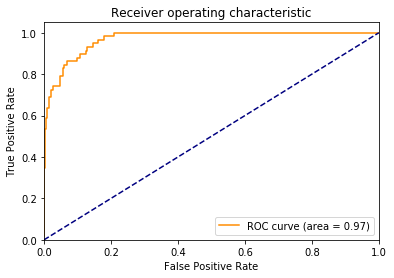

In [67]:
plt.figure()
plt.plot(fpr2, tpr2, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()